# Desarrollo Desafío Kaggle Tarea 1 INF 395

## Integrantes:

Tarea desarrollada por Grupo 02, conformado por:

* Nombre: Joaquín	García, Rol 201973087-8.
* Nombre: Gabriel	Díaz, Rol 201973095-9.
* Nombre: Bruno	Liberona, Rol 201973013-4.

## Dependencias

In [2]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
#pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 5.1 MB/s eta 0:00:00


## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from scikeras.wrappers import KerasRegressor
import seaborn as sns

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

# Define the random seed for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)


# for loading/processing the images
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
from random import randint
import pickle

Using TensorFlow backend


## Helper Functions

In [4]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [5]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [6]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

In [7]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

## Descarga Archivos Desafío

Para descargar los archivos del desafío se debe adjuntar el archivo "kaggle.json", el cual contiene tus credenciales de Kaggle con acceso al desafío.

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brunoliberona","key":"8f1ee487e39f05b1014c1bb038d3d1ed"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c inf-395-tarea-1

 97% 113M/116M [00:07<00:00, 16.4MB/s]
100% 116M/116M [00:07<00:00, 15.9MB/s]


In [11]:
!unzip /content/inf-395-tarea-1.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data_kaggle/imgs/bath_331.jpg  
  inflating: data_kaggle/imgs/bath_333.jpg  
  inflating: data_kaggle/imgs/bath_334.jpg  
  inflating: data_kaggle/imgs/bath_336.jpg  
  inflating: data_kaggle/imgs/bath_339.jpg  
  inflating: data_kaggle/imgs/bath_34.jpg  
  inflating: data_kaggle/imgs/bath_340.jpg  
  inflating: data_kaggle/imgs/bath_341.jpg  
  inflating: data_kaggle/imgs/bath_342.jpg  
  inflating: data_kaggle/imgs/bath_343.jpg  
  inflating: data_kaggle/imgs/bath_346.jpg  
  inflating: data_kaggle/imgs/bath_348.jpg  
  inflating: data_kaggle/imgs/bath_349.jpg  
  inflating: data_kaggle/imgs/bath_350.jpg  
  inflating: data_kaggle/imgs/bath_351.jpg  
  inflating: data_kaggle/imgs/bath_354.jpg  
  inflating: data_kaggle/imgs/bath_355.jpg  
  inflating: data_kaggle/imgs/bath_36.jpg  
  inflating: data_kaggle/imgs/bath_361.jpg  
  inflating: data_kaggle/imgs/bath_362.jpg  
  inflating: data_kaggle/imgs/bath_363.jp

## Preprocesamiento y Feature Engineering

### Lectura Dataframes

In [12]:
df = pd.read_csv('./data_kaggle/data/train_data.csv')

In [13]:
df_test_kaggle = pd.read_csv('./data_kaggle/data/test_data.csv')

In [ ]:
df.head()

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1276 non-null   int64  
 1   date           1276 non-null   object 
 2   zipcode        1276 non-null   int64  
 3   lat            1276 non-null   float64
 4   long           1276 non-null   float64
 5   bedrooms       1074 non-null   float64
 6   bathrooms      1079 non-null   float64
 7   sqft_living    1082 non-null   float64
 8   sqft_lot       1087 non-null   float64
 9   floors         1084 non-null   float64
 10  waterfront     1076 non-null   float64
 11  view           1082 non-null   float64
 12  condition      1095 non-null   float64
 13  grade          1086 non-null   float64
 14  sqft_above     1089 non-null   float64
 15  sqft_basement  1093 non-null   float64
 16  yr_built       1113 non-null   float64
 17  yr_renovated   1075 non-null   float64
 18  sqft_liv

In [14]:
# We first divide the data into train, train and validation dataframes
df_train, df_temporal = train_test_split(df, test_size = 0.2, train_size = 0.8, random_state = SEED)
df_test, df_valid = train_test_split(df_temporal, test_size = 0.5, train_size = 0.5, random_state = SEED)

### Imputación

In [ ]:
pd.DataFrame({ "have_null": df.isnull().any(),
               "total_null": df.isnull().sum(),
               "percentage_null": (df.isnull().sum() / df.count())*100,
               "dtype": df.dtypes })

,have_null,total_null,percentage_null,dtype
ID,False,0,0.000000,int64
date,False,0,0.000000,object
zipcode,False,0,0.000000,int64
lat,False,0,0.000000,float64
long,False,0,0.000000,float64
bedrooms,True,202,18.808194,float64
bathrooms,True,197,18.257646,float64
sqft_living,True,194,17.929760,float64
sqft_lot,True,189,17.387305,float64
floors,True,192,17.712177,float64


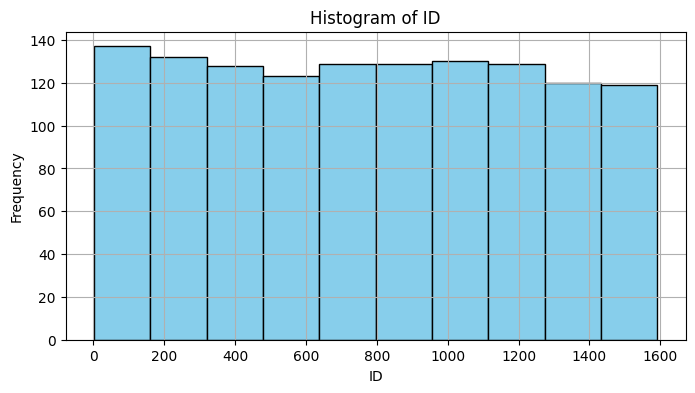

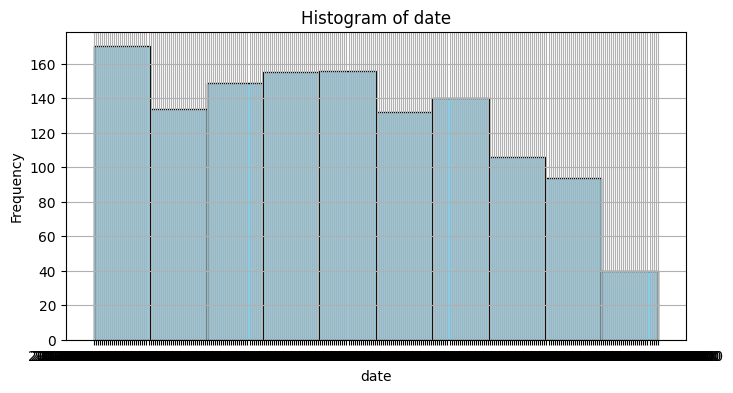

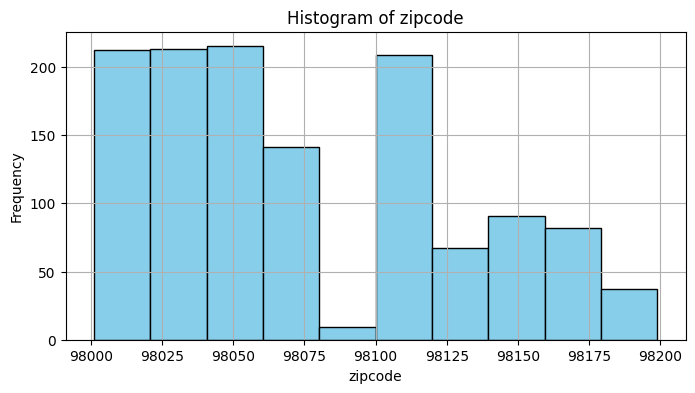

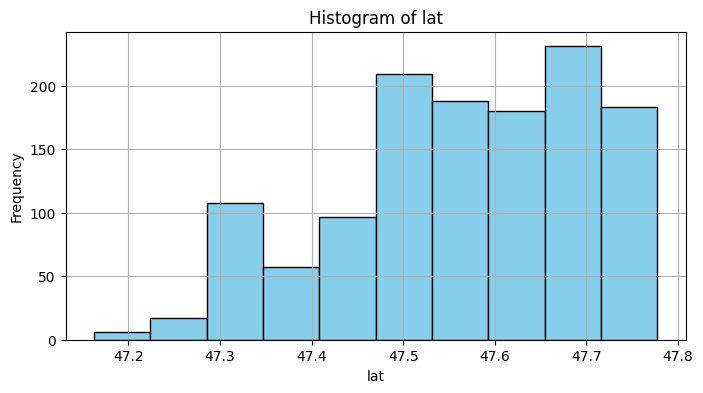

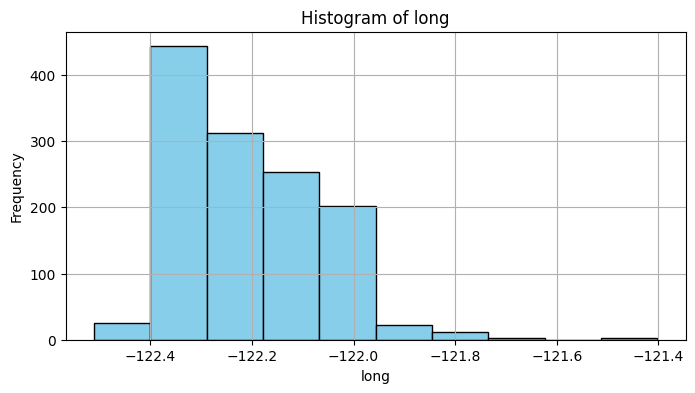

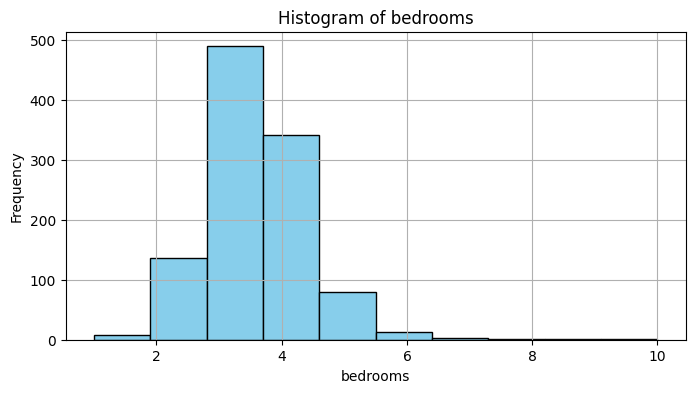

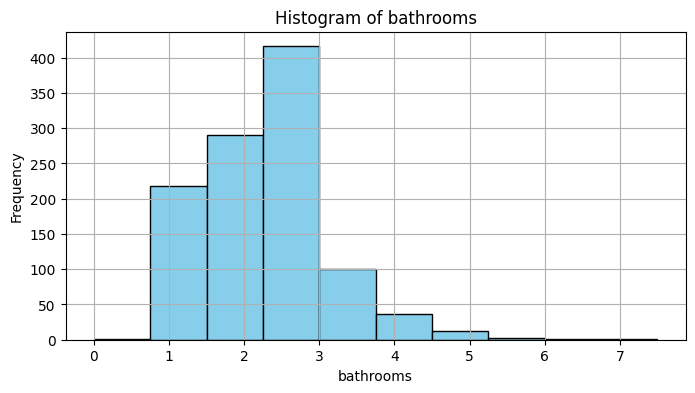

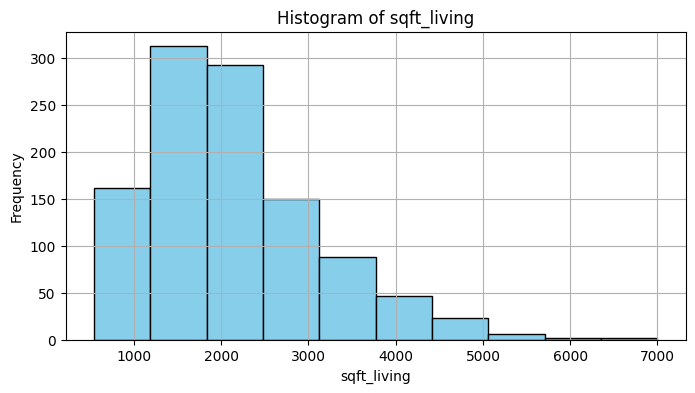

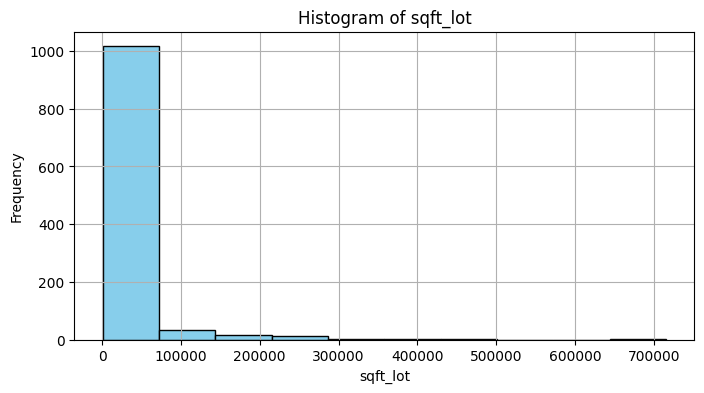

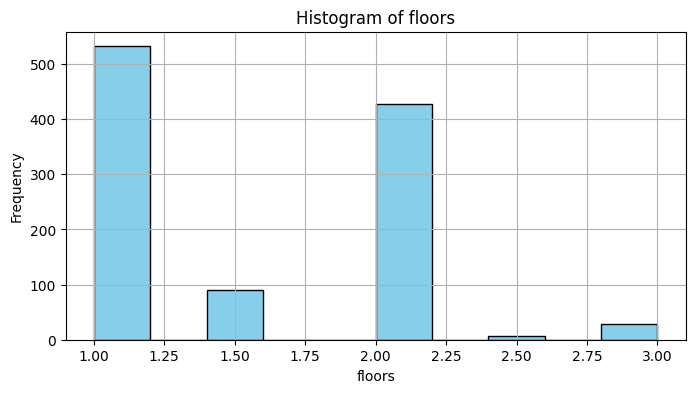

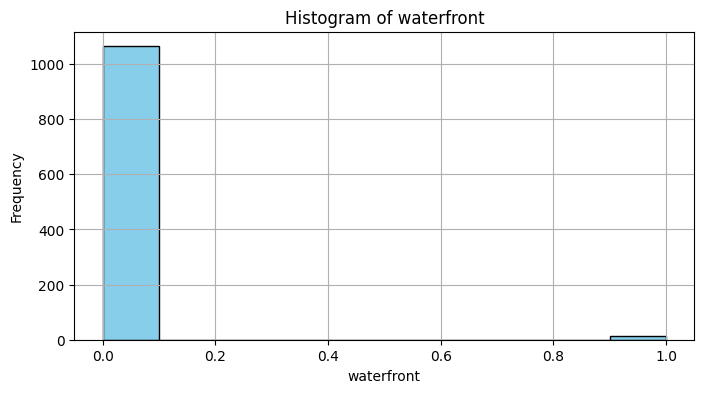

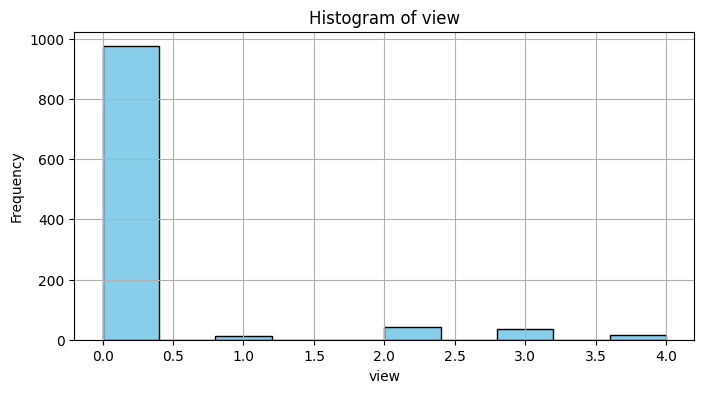

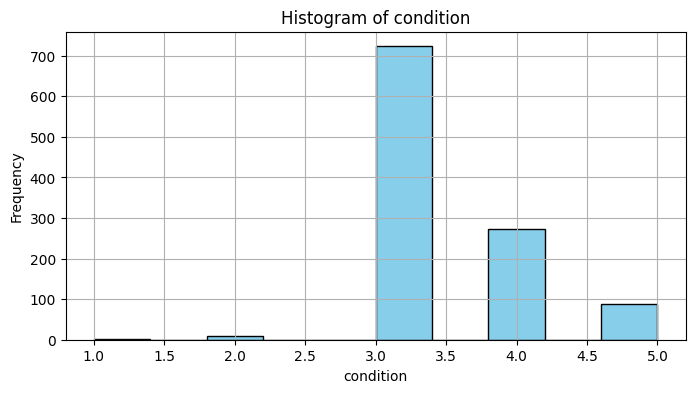

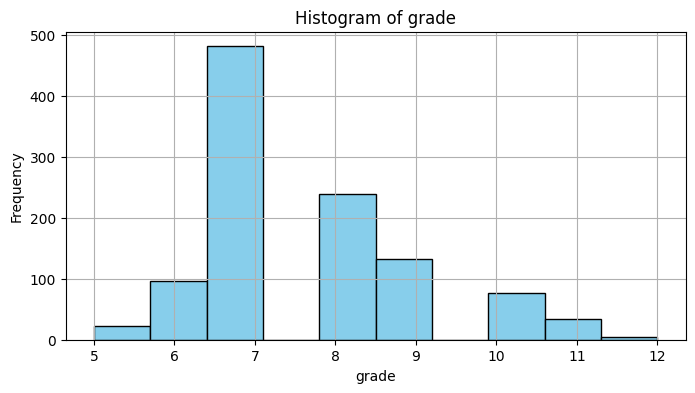

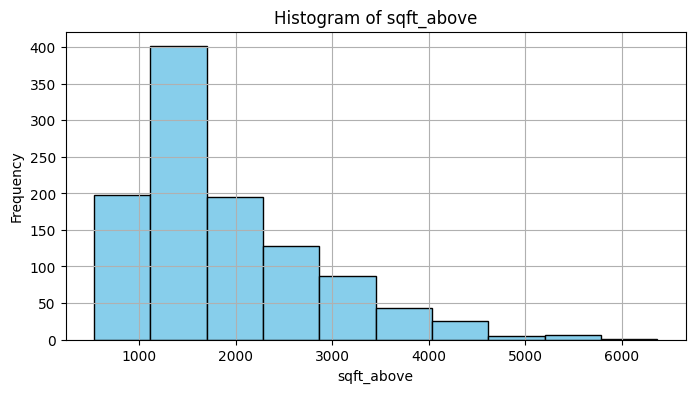

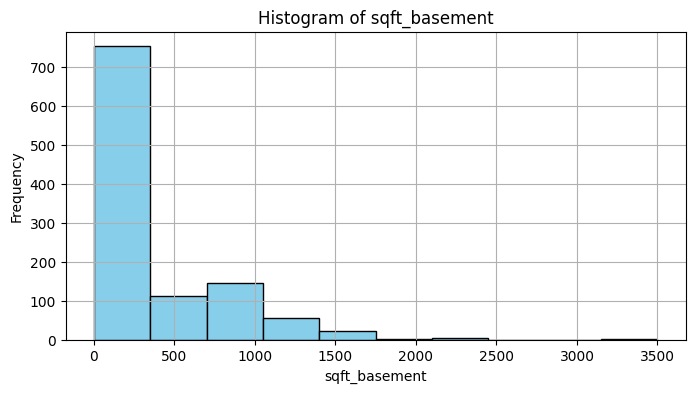

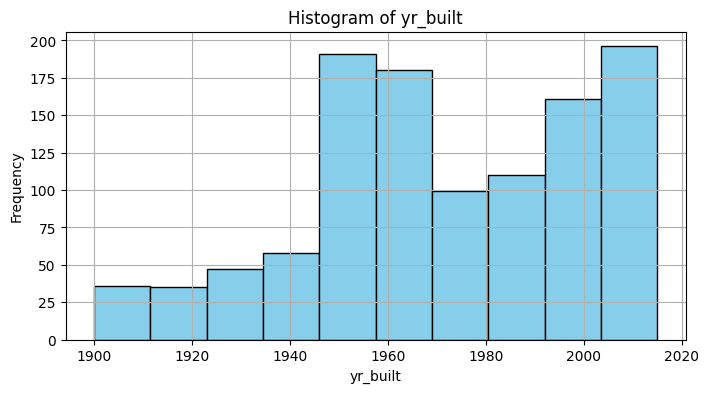

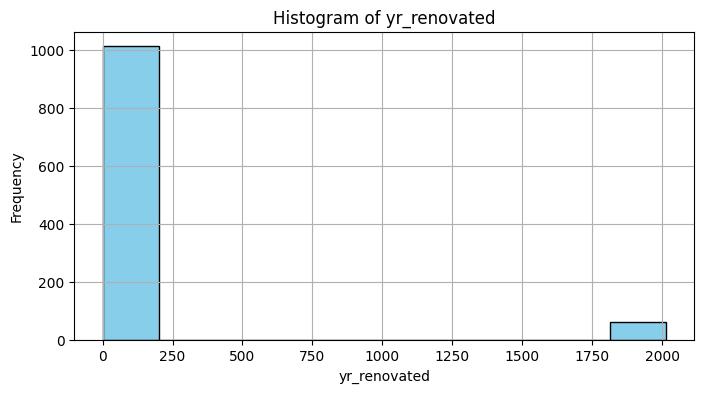

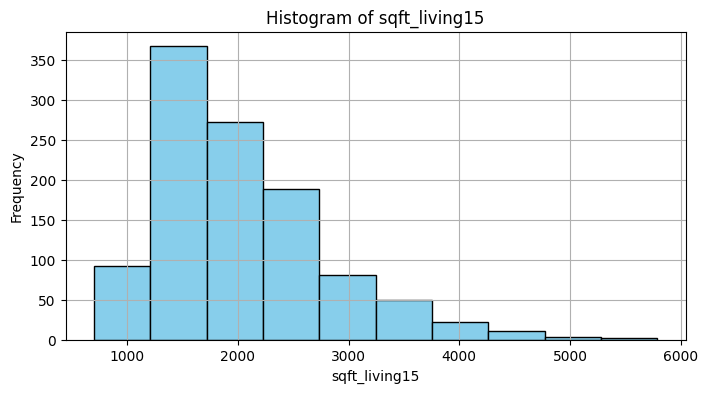

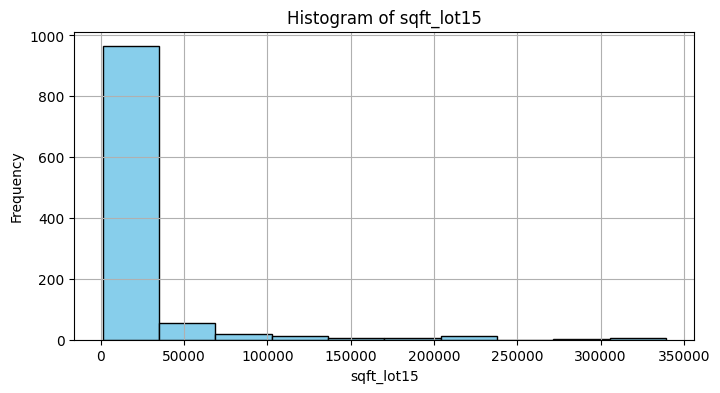

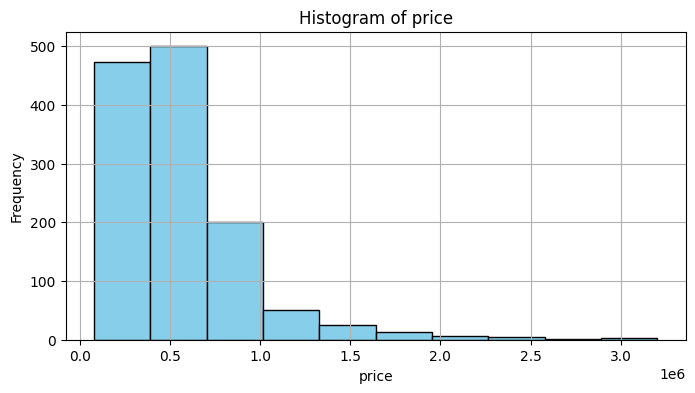

In [ ]:
# Get the list of column names (features)
features = df.columns

# Create histograms for each feature
for feature in features:
    plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
    plt.hist(df[feature], bins=10, color='skyblue', edgecolor='black')  # You can adjust the number of bins
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [15]:
# Features to impute:
## bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition
## grade, sqft_above, sqft_basement, yr_built, yr_renovated, sqft_living15, sqft_lot15

feat_imputation_mean = ["bedrooms"]
feat_imputation_median = ["bathrooms", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement",
                     "yr_built", "yr_renovated", "sqft_living15", "sqft_lot15"]
feat_imputation_mode = ["floors", "waterfront", "view", "condition", "grade"]

In [16]:
for feat in feat_imputation_mean:
  df_train[feat] = df_train[feat].fillna(df_train[feat].mean())
  df_valid[feat] = df_valid[feat].fillna(df_valid[feat].mean())
  df_test[feat] = df_test[feat].fillna(df_test[feat].mean())
  df_test_kaggle[feat] = df_test_kaggle[feat].fillna(df_test_kaggle[feat].mean())

for feat in feat_imputation_median:
  df_train[feat] = df_train[feat].fillna(df_train[feat].median())
  df_valid[feat] = df_valid[feat].fillna(df_valid[feat].median())
  df_test[feat] = df_test[feat].fillna(df_test[feat].median())
  df_test_kaggle[feat] = df_test_kaggle[feat].fillna(df_test_kaggle[feat].median())

for feat in feat_imputation_mode:
  df_train[feat] = df_train[feat].fillna(df_train[feat].mode()[0])
  df_valid[feat] = df_valid[feat].fillna(df_valid[feat].mode()[0])
  df_test[feat] = df_test[feat].fillna(df_test[feat].mode()[0])
  df_test_kaggle[feat] = df_test_kaggle[feat].fillna(df_test_kaggle[feat].mode()[0])

In [ ]:
print(df_train.isnull().any())
print(df_valid.isnull().any())
print(df_test.isnull().any())
print(df_test_kaggle.isnull().any())

ID               False
date             False
zipcode          False
lat              False
long             False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
sqft_living15    False
sqft_lot15       False
price            False
dtype: bool
ID               False
date             False
zipcode          False
lat              False
long             False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
sqft_living15    False
sqft_lot15       False
price            False
dtype: bool
ID        

### Transformaciones Features

In [17]:
# Making the feature ID the id of each row
# and transforming date into year, month and day

for df_it in [df_train, df_valid, df_test, df_test_kaggle]:
  df_it.set_index('ID', inplace=True)

  df_it['date'] = pd.to_datetime(df_it['date'])
  df_it['year'] = df_it['date'].dt.year
  df_it['month'] = df_it['date'].dt.month
  df_it['day'] = df_it['date'].dt.day

  df_it = preprocess_time(df_it, "month", 12)
  df_it = preprocess_time(df_it, "day", 30)

  df_it.drop('date', axis=1, inplace=True)

In [18]:
# Transforming Zipcode
for df_it in [df_train, df_valid, df_test, df_test_kaggle]:
  df_it['region_code'] = df_it['zipcode'].apply(lambda x: str(x)[1:3])
  df_it['region_code'] = df_it['region_code'].astype(np.int64)

  df_it['adress_code'] = df_it['zipcode'].apply(lambda x: str(x)[3:5])
  df_it['adress_code'] = df_it['adress_code'].astype(np.int64)

  df_it.drop("zipcode", axis=1, inplace=True)

In [19]:
current_year = 2023
for df_it in [df_train, df_valid, df_test, df_test_kaggle]:
  # Calculate age and years since renovation
  df_it['age'] = current_year - df_it['yr_built']
  df_it['years_since_renovation'] = current_year - df_it['yr_renovated']

  # For houses with no renovation, set 'years_since_renovation' to their age
  df_it['years_since_renovation'] = df_it.apply(lambda row: row['age'] if row['yr_renovated'] == 0.0 else row['years_since_renovation'], axis=1)

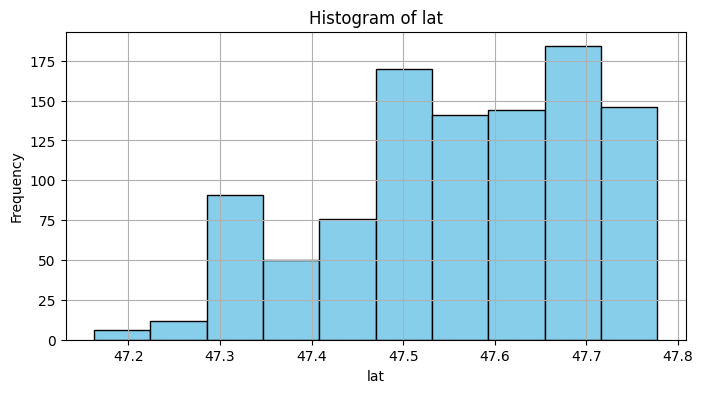

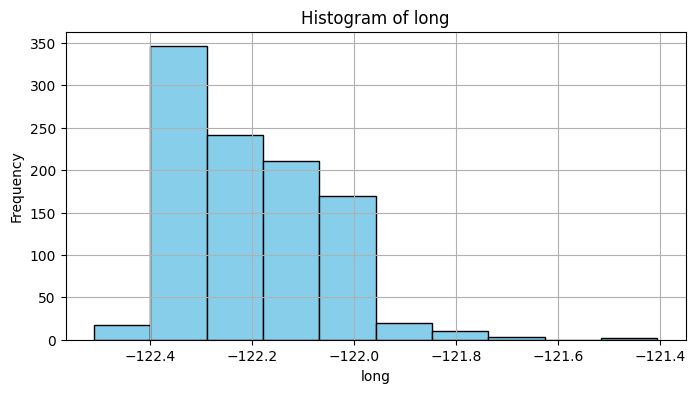

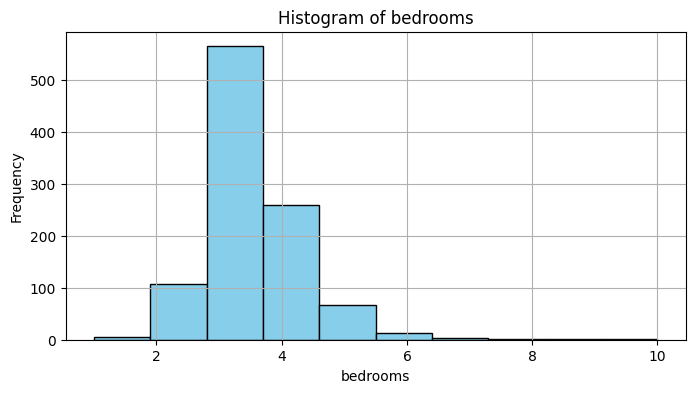

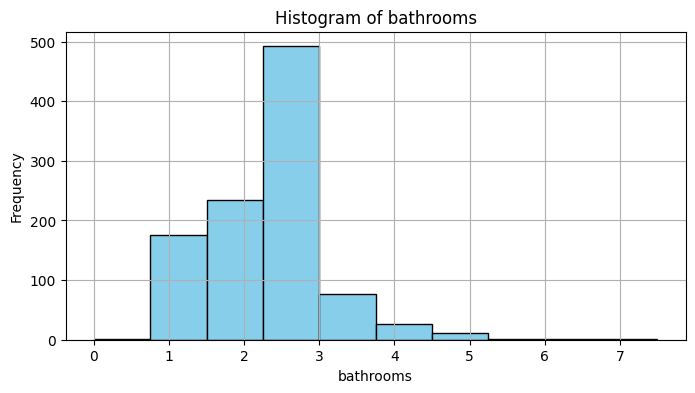

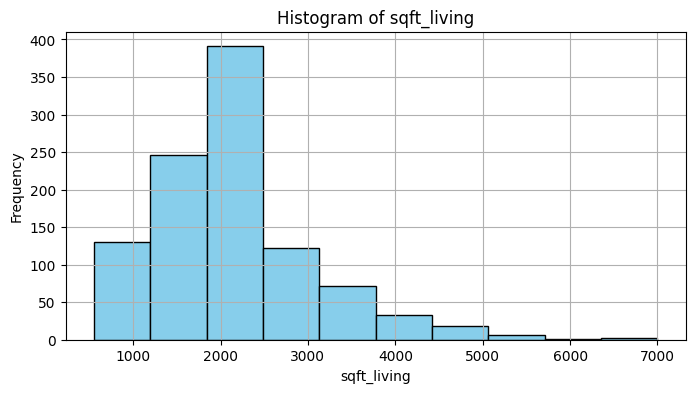

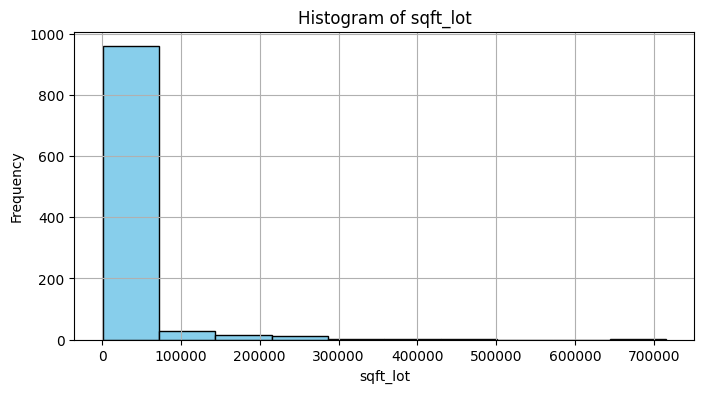

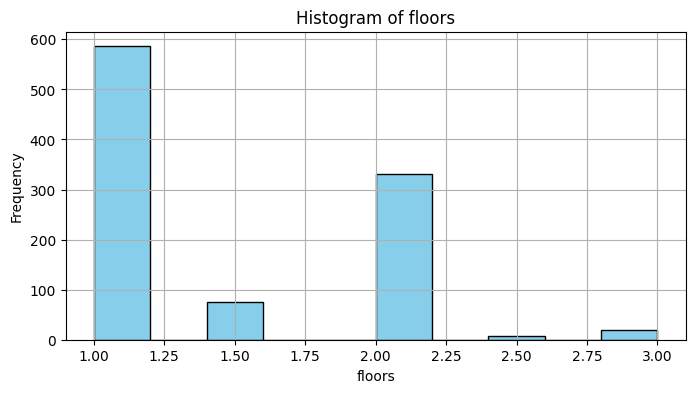

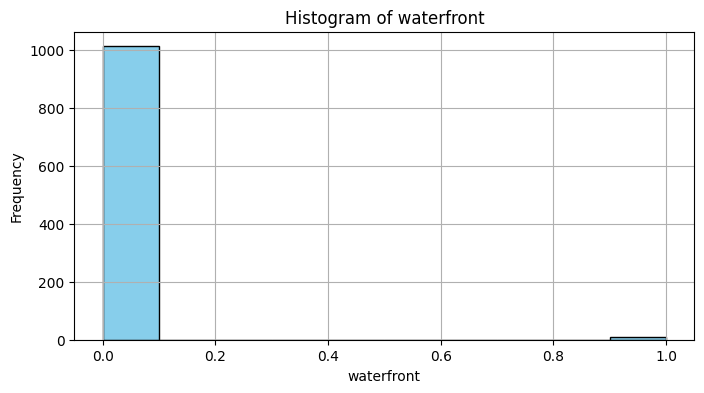

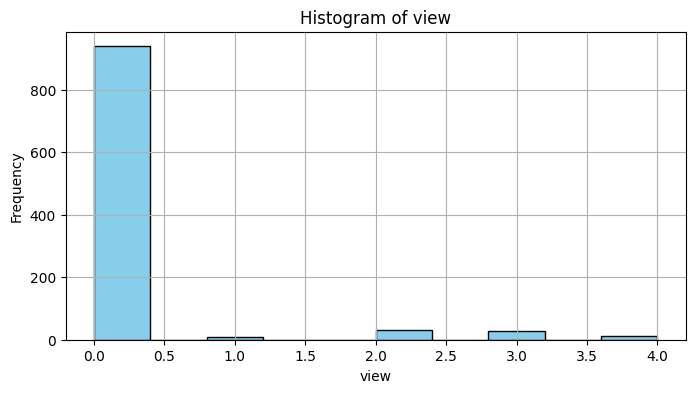

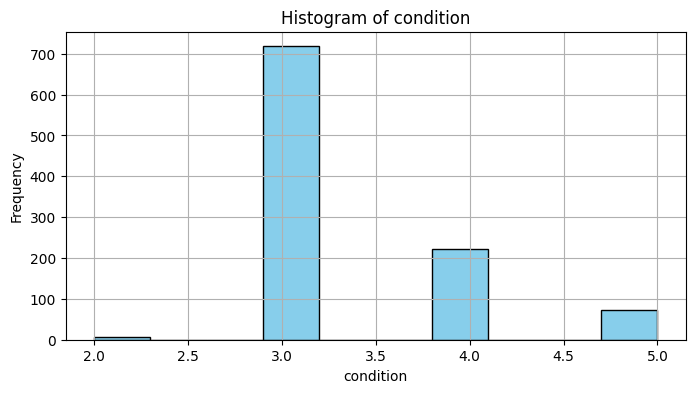

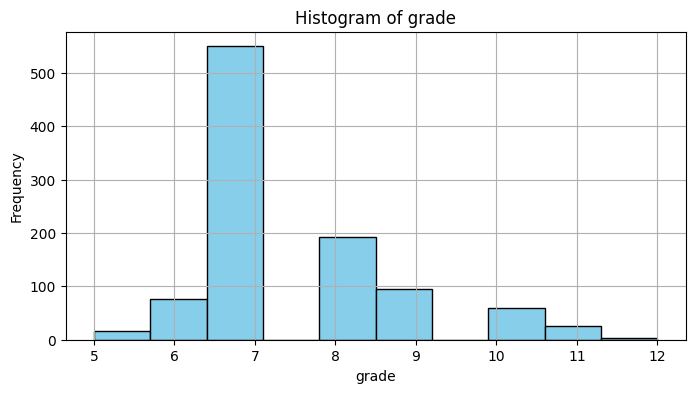

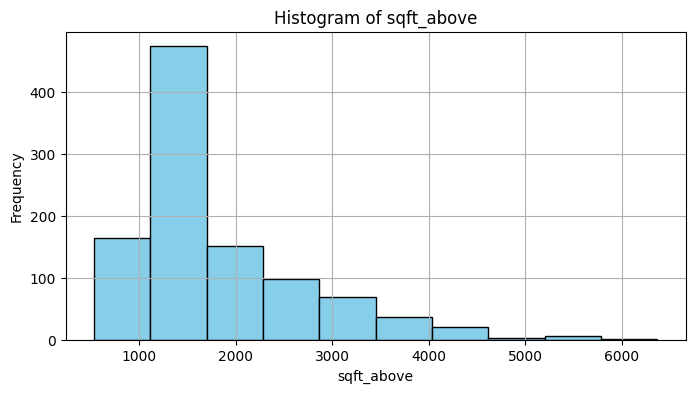

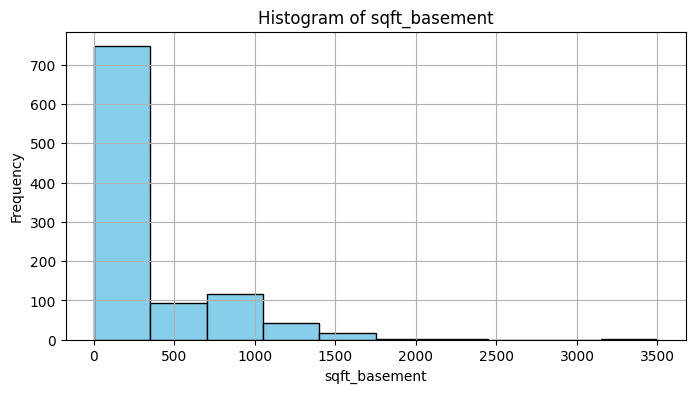

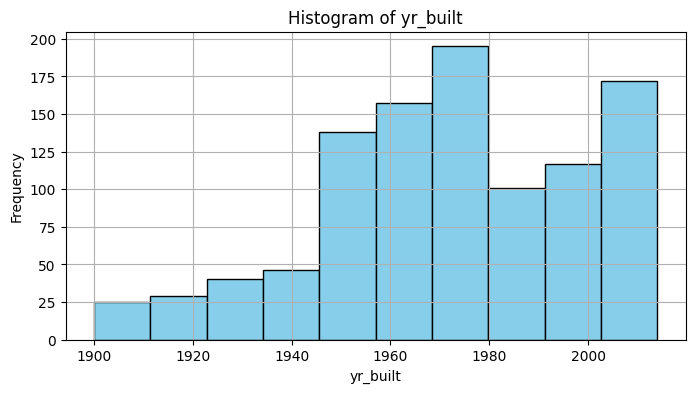

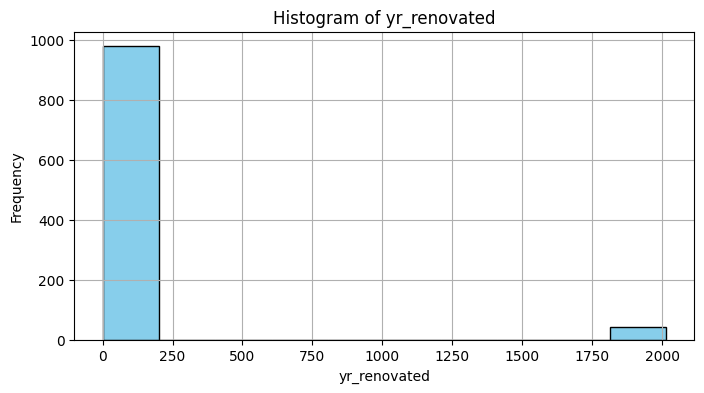

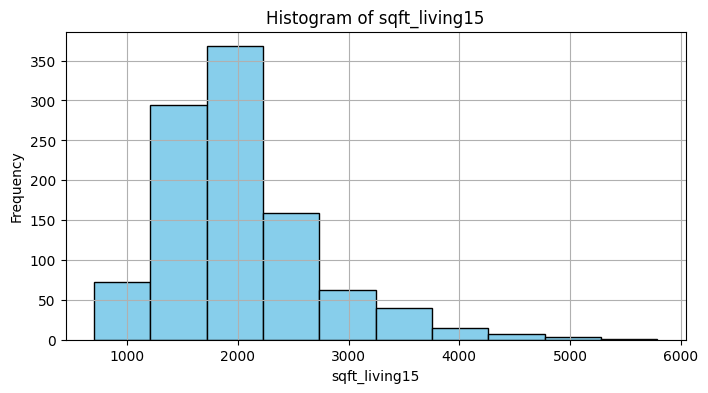

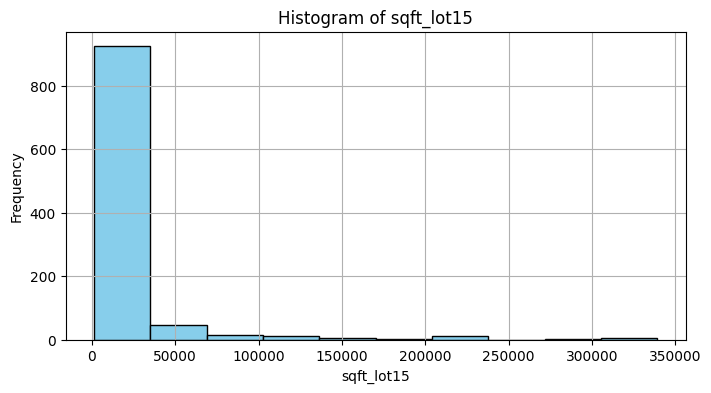

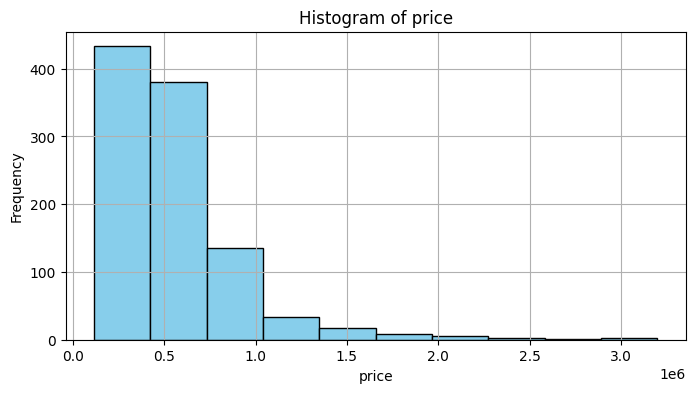

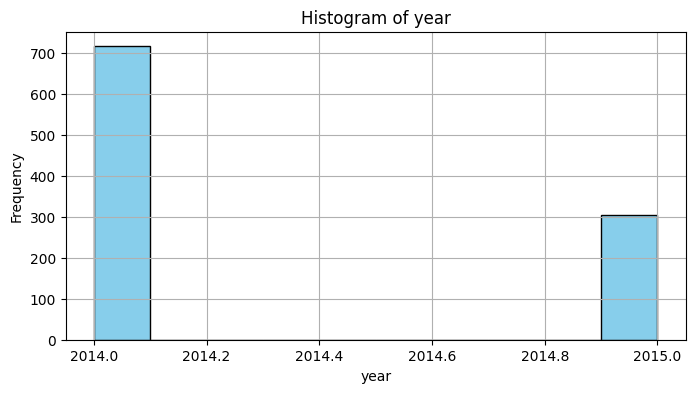

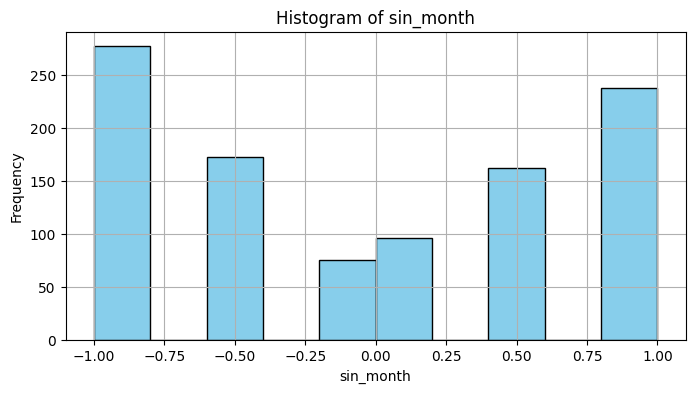

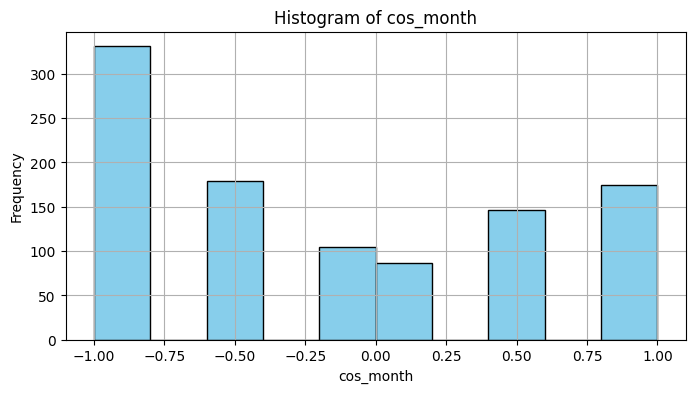

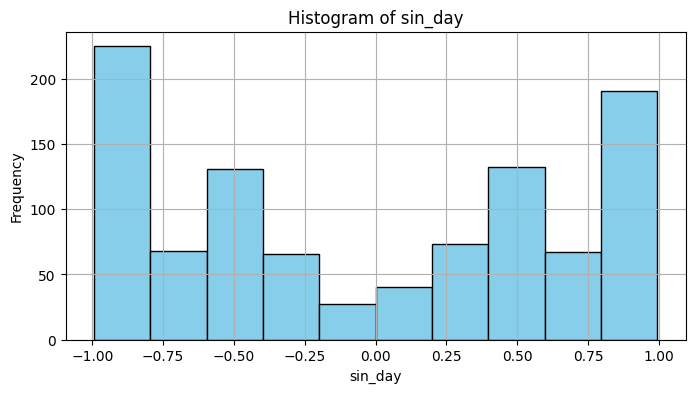

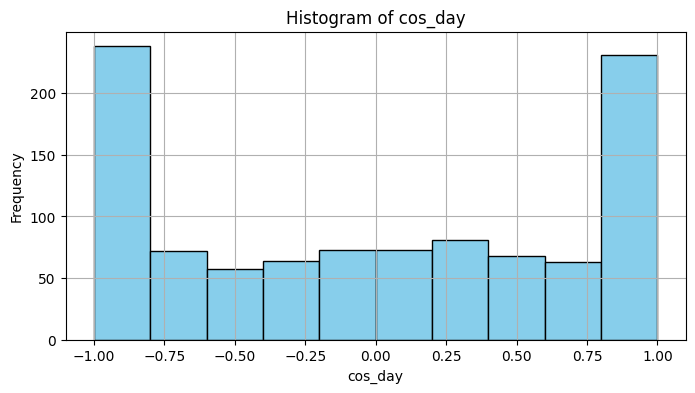

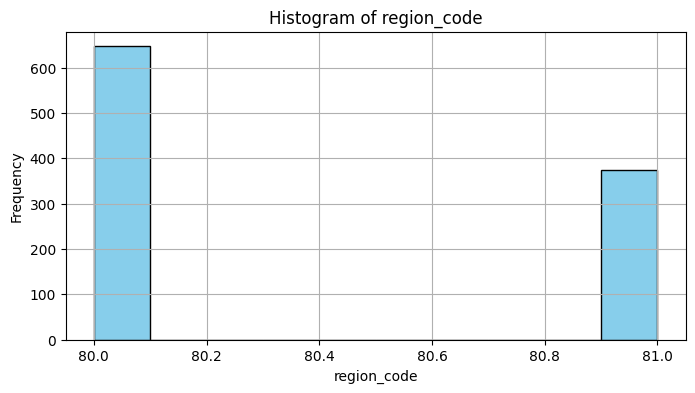

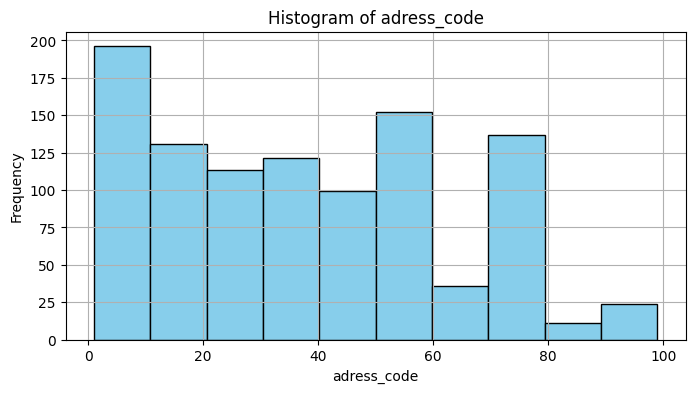

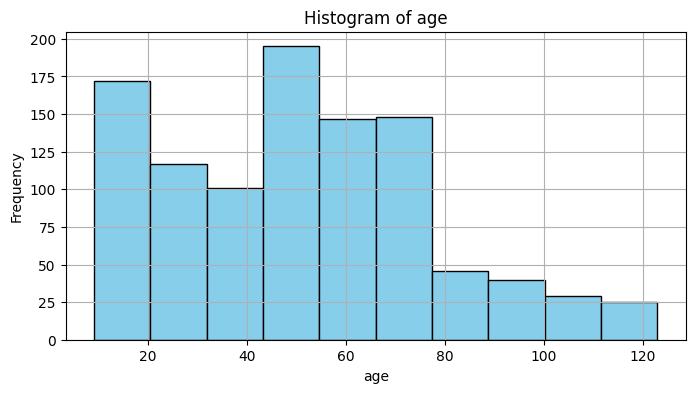

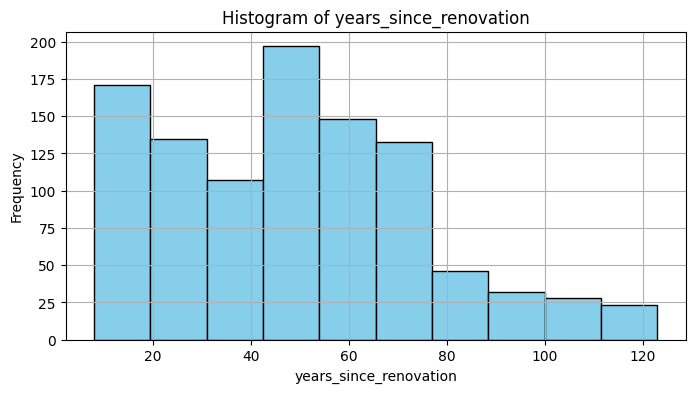

In [ ]:
for feature in df_train.columns:
    plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
    plt.hist(df_train[feature], bins=10, color='skyblue', edgecolor='black')  # You can adjust the number of bins
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [20]:
# 'lat', 'long', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
#        'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
#        'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
#        'sqft_lot15', 'price', 'year', 'sin_month', 'cos_month', 'sin_day',
#        'cos_day', 'region_code', 'adress_code', 'age',
#        'years_since_renovation'

feat_transform_minmax = ["lat", "long", "bedrooms", "floors", "waterfront", "view", "condition",
                         "grade", "year", "sin_month", "cos_month", "sin_day", "cos_day",
                         "region_code", "adress_code", "age", "years_since_renovation"]
feat_transform_strd = ["bathrooms", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement",
                     "yr_built", "yr_renovated", "sqft_living15", "sqft_lot15"]

In [21]:
minmax_scaler = MinMaxScaler()
strd_scaler = StandardScaler()

df_train[feat_transform_minmax] = minmax_scaler.fit_transform(df_train[feat_transform_minmax])
for df_it in [df_valid, df_test, df_test_kaggle]:
  df_it[feat_transform_minmax] = minmax_scaler.transform(df_it[feat_transform_minmax])

df_train[feat_transform_strd] = strd_scaler.fit_transform(df_train[feat_transform_strd])
for df_it in [df_valid, df_test, df_test_kaggle]:
  df_it[feat_transform_strd] = strd_scaler.transform(df_it[feat_transform_strd])

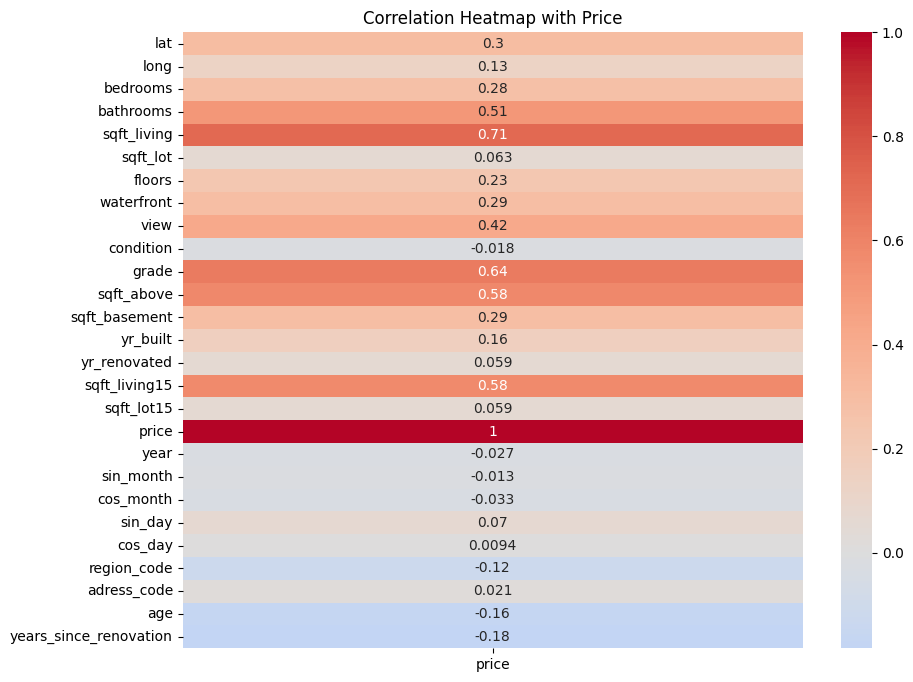

In [22]:
# Calculate the correlation between all features and the 'price' feature
price_correlation = df_train.corr()['price']

# Remove non-numeric columns (e.g., 'Weekday') from the DataFrame
numeric_df = df_train.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap using seaborn for the correlation with 'price'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['price']], annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap with Price')
plt.show()

### Separación en X and y sets

In [170]:
y_train = df_train['price']
X_train = df_train.drop(['price'], axis=1)  # Drop the target column from the feature set

y_valid = df_valid['price']
X_valid = df_valid.drop(['price'], axis=1)  # Drop the target column from the feature set

y_test = df_test['price']
X_test = df_test.drop(['price'], axis=1)  # Drop the target column from the feature set

X_test_kaggle = df_test_kaggle

### Drop Features según Mutual Information

Text(0.5, 1.0, 'Mutual information between predictors and target')

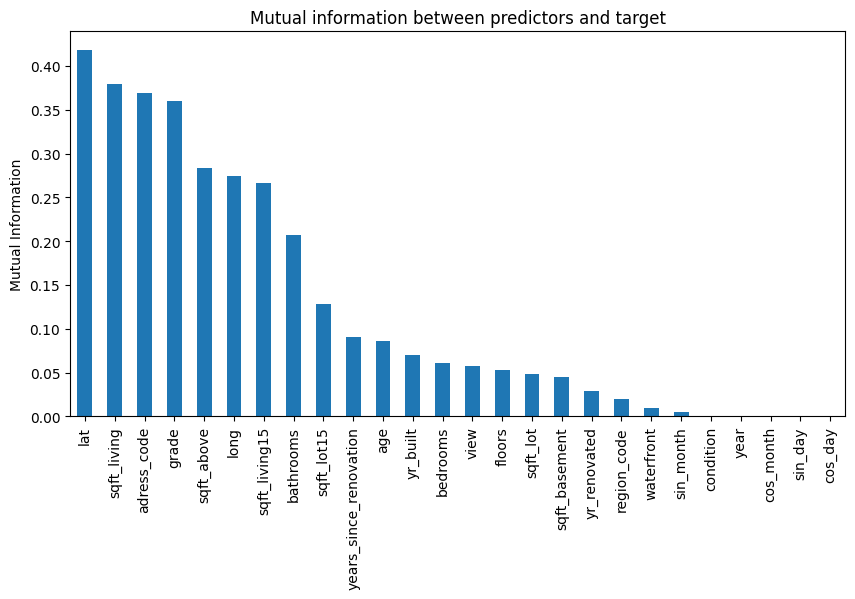

In [171]:
mi = mutual_info_regression(X_train, y_train)
mi = pd.Series(mi)

mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('Mutual Information')
plt.title("Mutual information between predictors and target")

In [172]:
# Número de features a elegir
n = len(mi) - 10

# Sort de los features respecto a su mi score
sorted_indices = np.argsort(mi)

# Se eligen las mejores n
selected_indices = sorted_indices[-n:]

# Se eliminan las peores features y se mantienen las mejores n
no_selected_indices = (sorted_indices[:-n]).tolist()
X_train = X_train.drop(X_train.columns[no_selected_indices], axis=1)
X_valid = X_valid.drop(X_valid.columns[no_selected_indices], axis=1)
X_test = X_test.drop(X_test.columns[no_selected_indices], axis=1)
X_test_kaggle = X_test_kaggle.drop(X_test_kaggle.columns[no_selected_indices], axis=1)

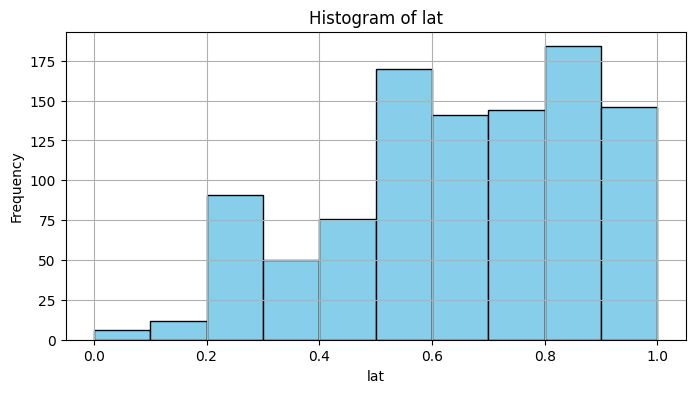

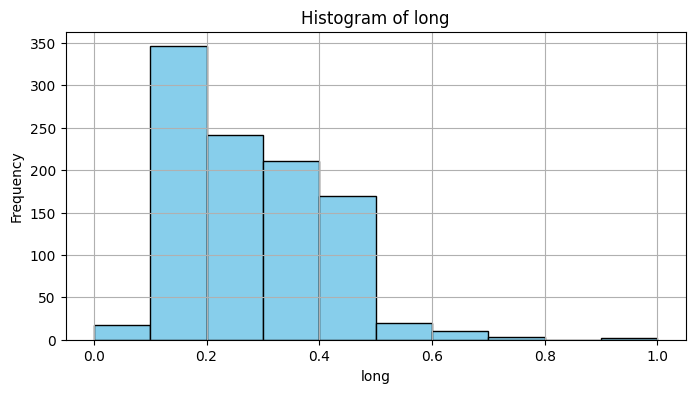

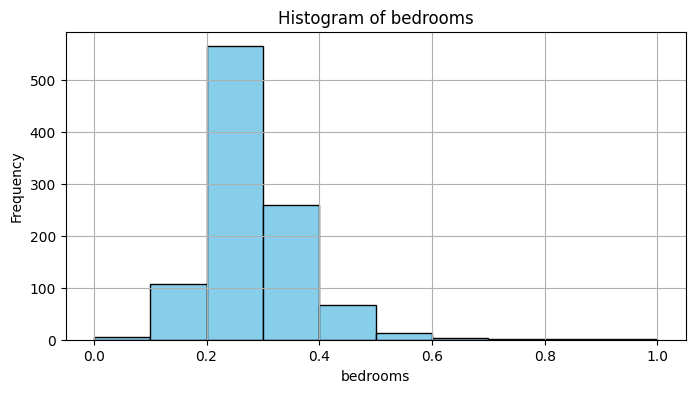

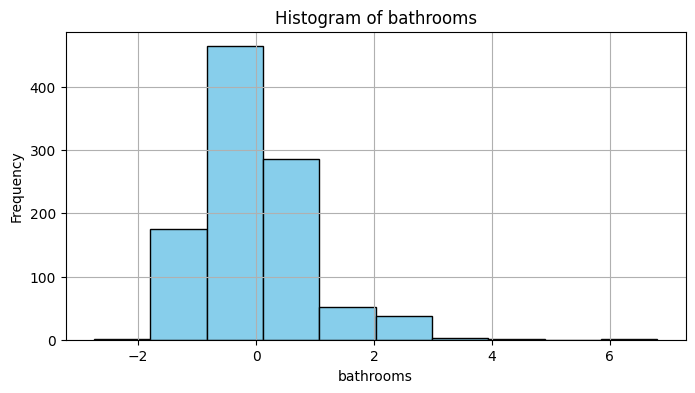

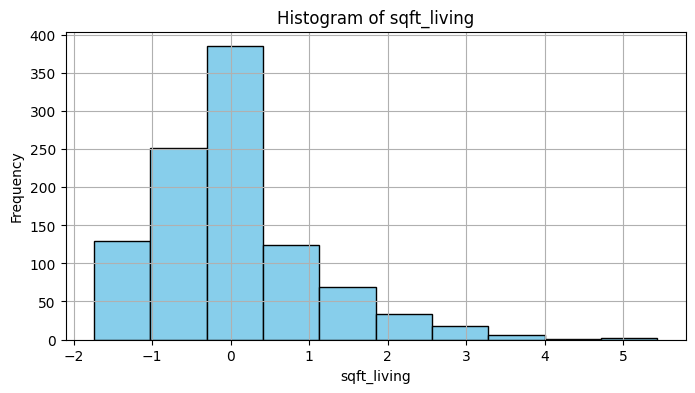

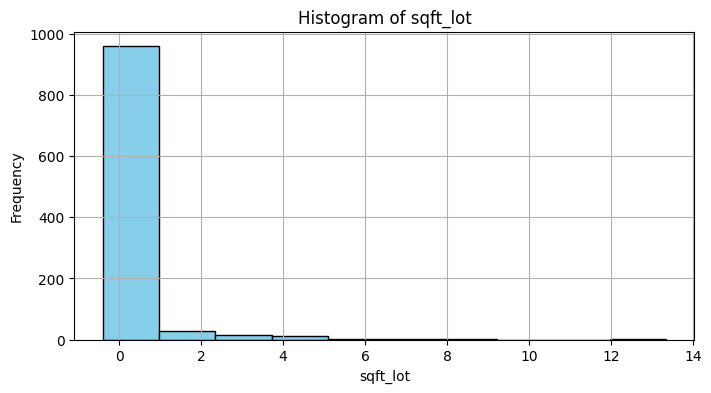

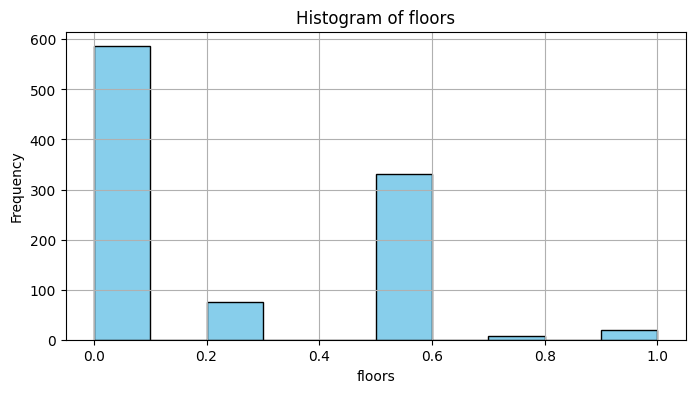

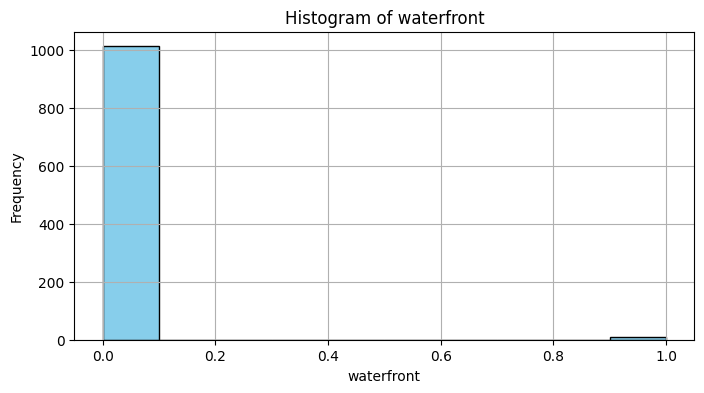

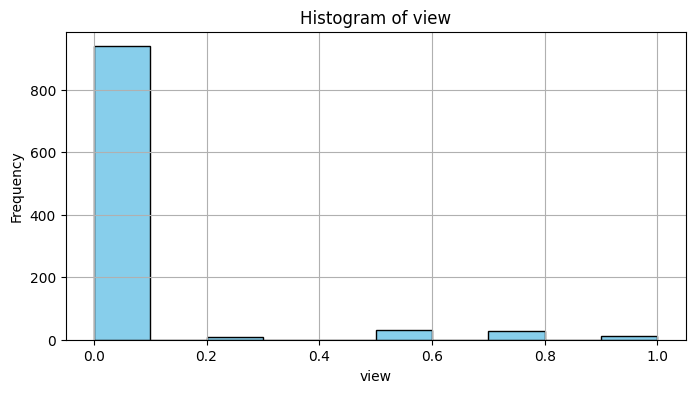

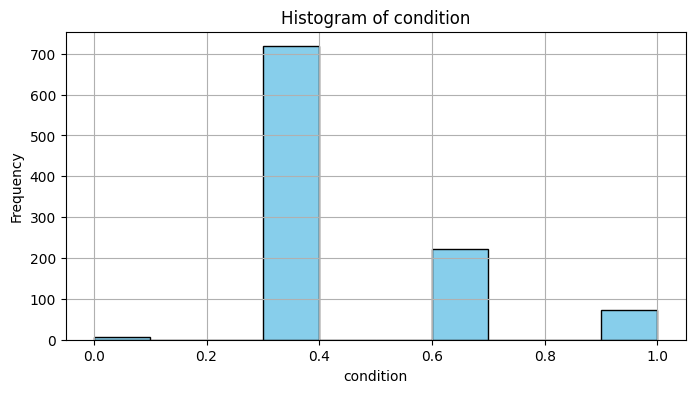

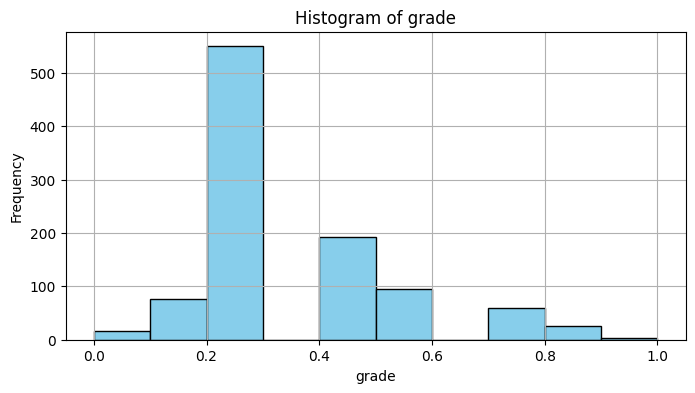

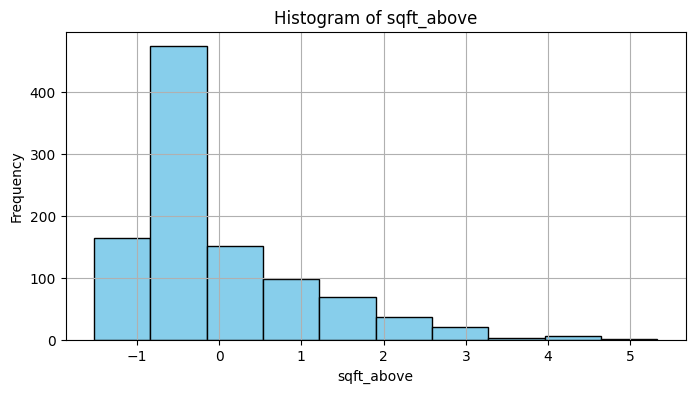

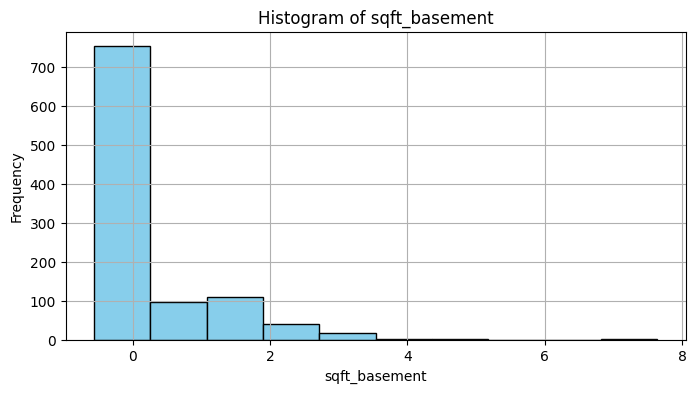

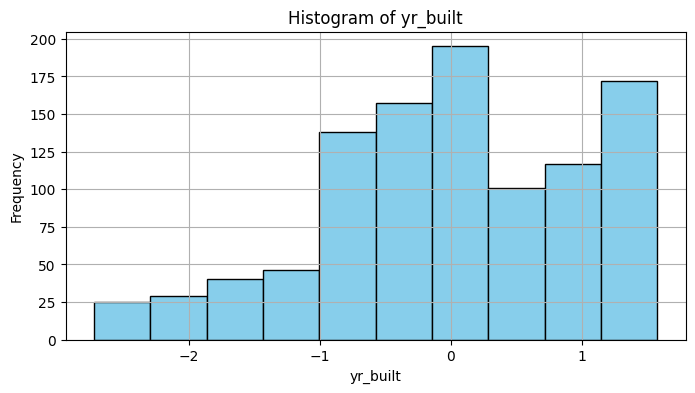

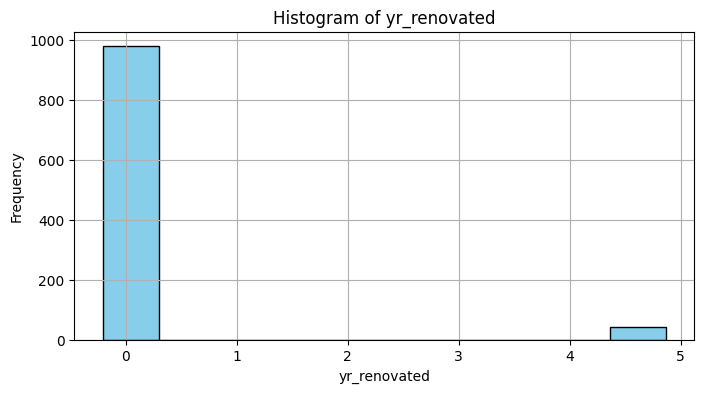

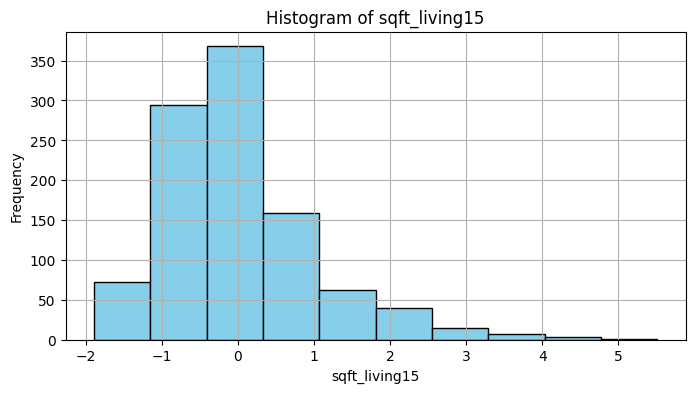

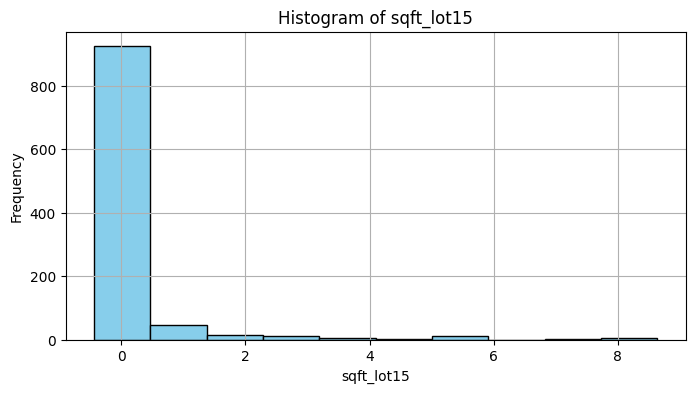

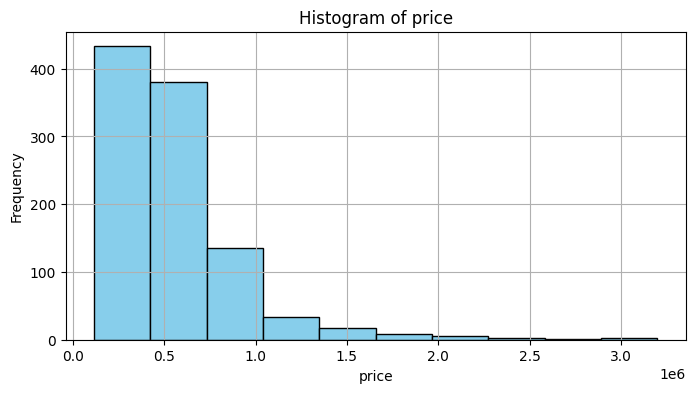

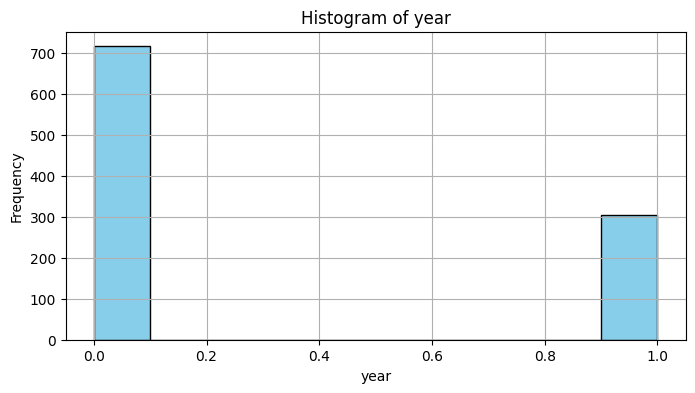

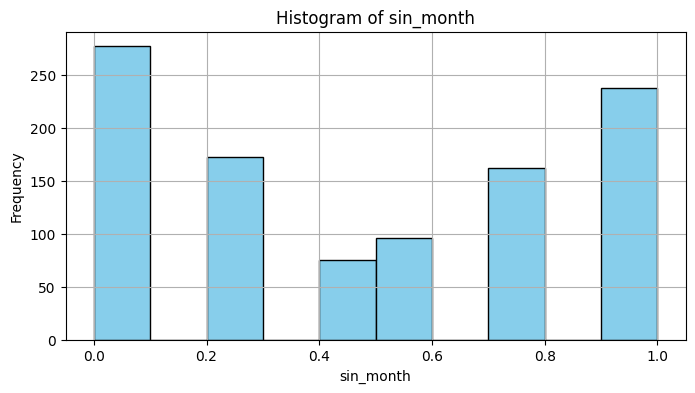

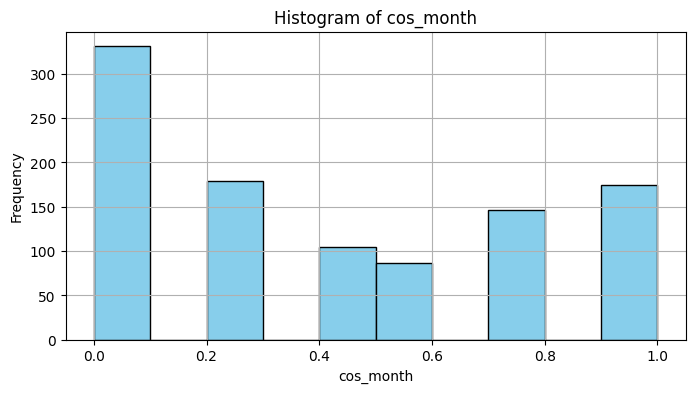

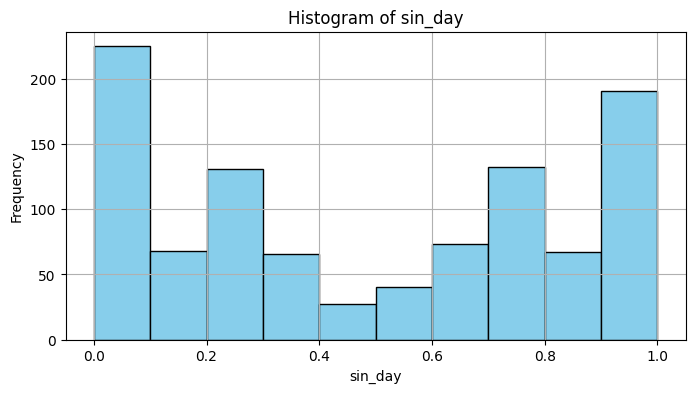

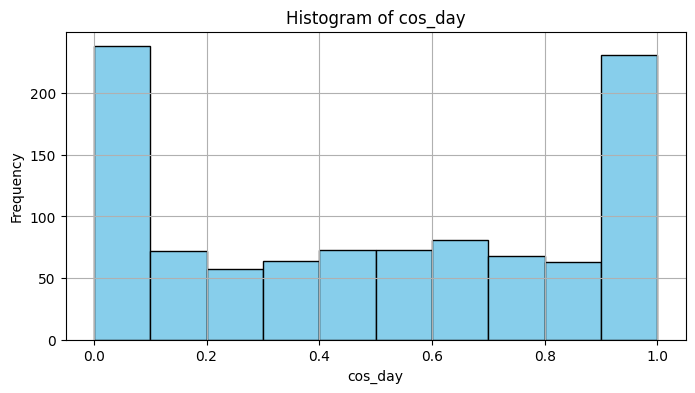

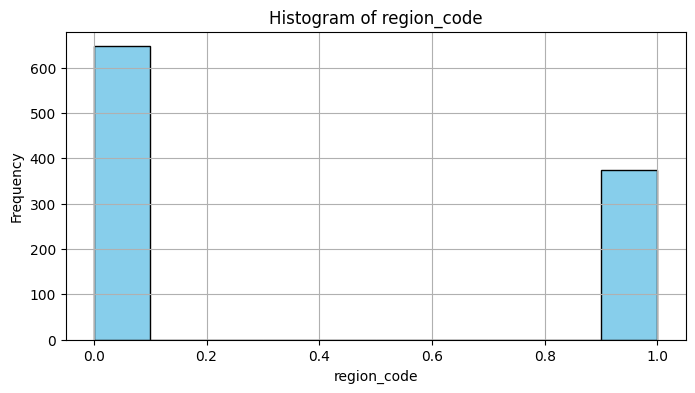

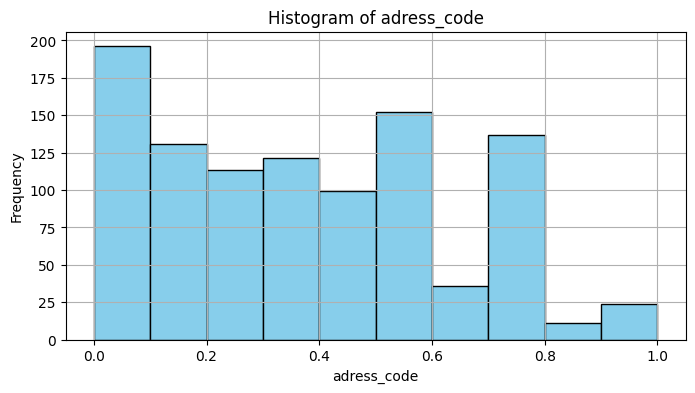

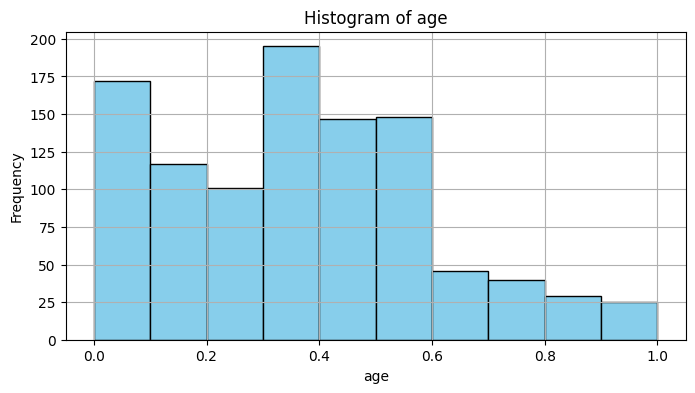

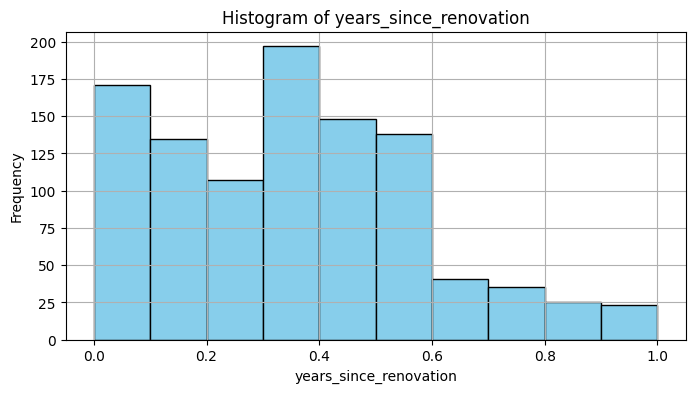

In [173]:
for feature in df_train.columns:
    plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
    plt.hist(df_train[feature], bins=10, color='skyblue', edgecolor='black')  # You can adjust the number of bins
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [174]:
X_train.shape

(1020, 16)

## Red Neuronal y Entrenamiento

In [186]:
inputs = keras.layers.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(inputs)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(16, activation='relu', kernel_initializer="he_normal")(x)

output = keras.layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_252 (Dense)               │ (None, 1024)              │     17,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_211 (Dropout)           │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_253 (Dense)               │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_212 (Dropout)           │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_254 (Dense)               │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_213 (Dropout)           │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_255 (Dense)               │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_214 (Dropout)           │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_256 (Dense)               │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_215 (Dropout)           │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_257 (Dense)               │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_216 (Dropout)           │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_258 (Dense)               │ (None, 16)                │        528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_259 (Dense)               │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 717,313 (2.74 MB)

 Trainable params: 717,313 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

In [187]:
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-4)

model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error"])

In [189]:
# Hiperparámetros
epochs = 800
batch_size = 64
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=20,
      restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        patience=5,
        min_lr=1e-6
    )
]

In [190]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data = (X_valid, y_valid.values),
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 446700290048.0000 - mean_squared_error: 446718740359.5294 - val_loss: 479639437312.0000 - val_mean_squared_error: 479639437312.0000 - learning_rate: 1.0000e-04
Epoch 2/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 446700290048.0000 - mean_squared_error: 446718740359.5294 - val_loss: 479639076864.0000 - val_mean_squared_error: 479639076864.0000 - learning_rate: 1.0000e-04
Epoch 3/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 446700164758.5883 - mean_squared_error: 446718615070.1177 - val_loss: 479638290432.0000 - val_mean_squared_error: 479638290432.0000 - learning_rate: 1.0000e-04
Epoch 4/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 446699574934.5883 - mean_squared_error: 446718025246.1177 - val_loss: 479636488192.0000 - val_mean_squared_error: 479636488192.0000 - learning_rate: 1.0000e-04
Epoch 5/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 446697678245.6470 - mean_squared_error: 446716124702.1177 -

In [191]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Mean Squared Error: 69616373205.02243


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


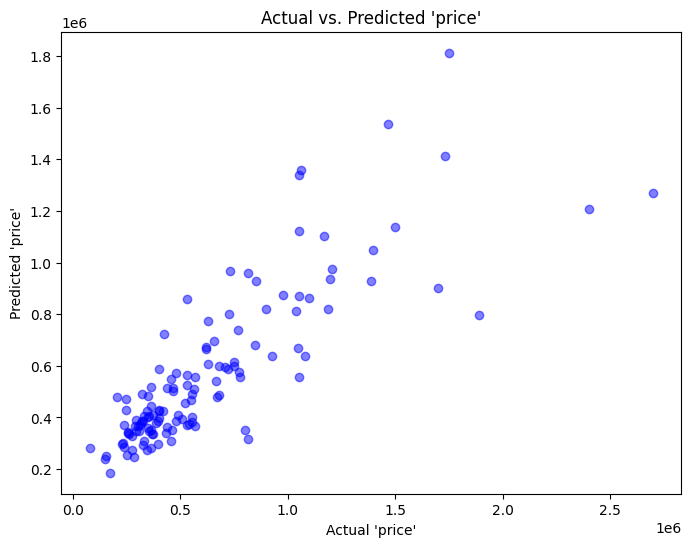

In [192]:
y_pred = model.predict(X_test)  # Predicted values

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.title("Actual vs. Predicted 'price'")
plt.xlabel("Actual 'price'")
plt.ylabel("Predicted 'price'")
plt.show()

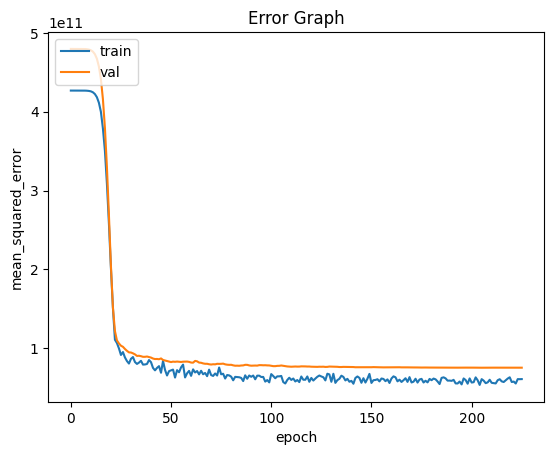

In [193]:
plot_losses(history, loss)

In [194]:
y_pred_kaggle = model.predict(X_test_kaggle)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [195]:
df_test_kaggle_predicted = pd.DataFrame({'ID': X_test_kaggle.index, 'price': [val[0] for val in y_pred_kaggle]})

In [196]:
df_test_kaggle_predicted

,ID,price
0,1473,1.244898e+06
1,716,3.467423e+05
2,1360,1.023733e+06
3,1522,4.843742e+05
4,1570,2.398922e+05
...,...,...
315,1475,3.843468e+05
316,374,5.018571e+05
317,795,6.393244e+05
318,888,2.351720e+05


In [197]:
df_test_kaggle_predicted.to_csv("grupo02_predict_tarea1.csv", index=False)